<a href="https://colab.research.google.com/github/JohEder/bachelor_thesis_audio_ml/blob/master/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchaudio
!pip install pytorch-model-summary

     |████████████████████████████████| 1.9MB 6.6MB/s 


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import os
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
import time
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from scipy.special import softmax

In [3]:
#just copied the official import script for the dataset, custom preprocessing happens afterwards
""" Import script for IDMT-Traffic dataset
Ref:
    J. Abeßer, S. Gourishetti, A. Kátai, T. Clauß, P. Sharma, J. Liebetrau: IDMT-Traffic: An Open Benchmark
    Dataset for Acoustic Traffic Monitoring Research, EUSIPCO, 2021
"""

import os
import glob
import pandas as pd

__author__ = 'Jakob Abeßer (jakob.abesser@idmt.fraunhofer.de)'


def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """ Import IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file with all WAV files
    Returns:
        df_dataset (pd.Dataframe): File-wise metadata
            Columns:
                'file': WAV filename,
                'is_background': True if recording contains background noise (no vehicle), False else
                'date_time': Recording time (YYYY-MM-DD-HH-mm)
                'location': Recording location
                'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
                'sample_pos': Sample position (centered) within the original audio recording,
                'daytime': M(orning) or (A)fternoon,
                'weather': (D)ry or (W)et road condition,
                'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
                'source_direction': Source direction of passing vehicle: from (L)eft or from (R)ight,
                'microphone': (SE)= (high-quality) sE8 microphones, (ME) = (low-quality) MEMS microphones (ICS-43434),
                'channel': Original stereo pair channel (12) or (34)
    """
    # load file list
    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    # load metadata from file names
    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                           'is_background': is_background,
                           'date_time': date_time,
                           'location': location,
                           'speed_kmh': speed_kmh,
                           'sample_pos': sample_pos,
                           'daytime': daytime,
                           'weather': weather,
                           'vehicle': vehicle,
                           'source_direction': source_direction,
                           'microphone': mic,
                           'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                                   'source_direction', 'microphone', 'channel'))

    return df_dataset

In [4]:
"""
Anomalous Sound Transformer Model for my Bachelor Thesis
"""

__author__ = 'Johannes Eder (Jo.Eder@campus.lmu.de)'

#print(len(all_data[all_data.is_background])) #8144 -> #9362 labbelled background sounds
#print(len(all_data[all_data.vehicle == 'C'])) #7804
#print(len(all_data[all_data.vehicle == 'M'])) #430
#print(len(all_data[all_data.vehicle == 'T'])) #1022
#print(len(all_data[all_data.vehicle == 'B'])) #106

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
CLASSES = ['None','C','T', 'M', 'B'] #Background Noise, Car, Truck, Motorcycle, Bus
NORMAL_CLASSES = ['None', 'C']
ANOMALOUS_CLASSES = ['T', 'M', 'B']

SAMPLE_RATE = 22500
N_FFT=2048 #is also window size
HOP_LENGTH=1024
N_MELS=128
NUMBER_OF_FRAMES = 4
melspectogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT, # Frame Size
        hop_length=HOP_LENGTH, #here half the frame size
        n_mels=N_MELS
    )

transforms = transforms.Compose([
    transforms.ToPILImage(mode='L'),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.Resize([224, 224]),
    #transforms.RandomCrop(size=[N_MELS, NUMBER_OF_FRAMES]), #only train on random slice of the spectogram
    transforms.ToTensor(),
])

AUDIO_DIR = "/content/drive/My Drive/datasets/IDMT_Traffic/audio"
train_annotations = "/content/drive/My Drive/datasets/IDMT_Traffic/annotation/eusipco_2021_train.csv"
test_annotatons = "/content/drive/My Drive/datasets/IDMT_Traffic/annotation/eusipco_2021_test.csv"
all_annotations_txt = "/content/drive/My Drive/datasets/IDMT_Traffic/annotation/idmt_traffic_all.txt"

BATCH_SIZE = 64
BATCH_SIZE_VAL = 1


NUMBER_OF_FRAMES = 2
EMBEDDING_SIZE = 512
N_HEADS = 8
N_ENCODER_LAYERS = 8
DROPOUT = 0.2 #is dropout needed for AD?
DIM_FEED_FORWARD = 512
input_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class IdmtTrafficDataSet(Dataset):

    def __init__(self, annotations_file, audio_dir, audio_transformation, transformation, target_sample_rate, normal_classes):
        self.annotations =  annotations_file if isinstance(annotations_file, pd.DataFrame) else pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.audio_transformation = audio_transformation
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        #self.classes = ['None','C','T', 'M', 'B']
        self.normal_classes = normal_classes


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample(signal, sr) #adjust sample rates
        # signal -> (num_channels, samples) i.e. (2, 16000)
        signal  = self._mix_down(signal) #stereo to mono
        signal = self.audio_transformation(signal) #(1, 16000) -> torch.Size([1, 64, 63])
        signal = self.transformation(signal)
        #label = self.normal_classes.index(label)
        label = 0 if label in self.normal_classes else 1
        return signal, label

    def _resample(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal
    
    def _mix_down(self, signal):
        if signal.shape[0] > 1: #(2, 16000)
            #mean operation: aggregating multiple channels
            signal = torch.mean(signal, 0, True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path + '.wav'

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 9]

In [8]:
def get_normal_and_anomalous_data(normal_classes, anomalous_classes, audio_dir, annotations, batch_size):
    if len((set(normal_classes) & set(anomalous_classes))) > 0:
      raise Exception("Intersection between normal and anomalous classes should be empty!")

    all_data = import_idmt_traffic_dataset(annotations)

    normal_data = all_data[all_data.vehicle.isin(normal_classes)]
    anomalous_data = all_data[all_data.vehicle.isin(anomalous_classes)]

    train_data = normal_data.iloc[:5000, :] #test data needs to have some amount of normal data as well, maybe take always 10 percent of the normal trainig data as anomalous
    train_data = adjust_sample_number_to_batch_size(train_data, batch_size)
    print(f"training with {len(train_data)}")

    normal_test_data = normal_data.iloc[5001:5101, :] #later more all test samples need to be used, but for now it is faster
    number_of_normal_test_sampels = len(normal_test_data)
    print(f"testing with {number_of_normal_test_sampels} normal samples")

    #sample same number of anomalous data to test
    anomalous_data = anomalous_data.sample(number_of_normal_test_sampels)
    print(f"testing with {len(anomalous_data)} anomalous samples")

    frames = [anomalous_data, normal_test_data]
    concatenated_test_data = pd.concat(frames)
    concatenated_test_data.reset_index(drop=True, inplace=True)
    concatenated_test_data = adjust_sample_number_to_batch_size(concatenated_test_data, batch_size)

    normal_train_data = IdmtTrafficDataSet(train_data, audio_dir, melspectogram, transforms, SAMPLE_RATE, normal_classes)
    test_data = IdmtTrafficDataSet(concatenated_test_data, audio_dir, melspectogram, transforms, SAMPLE_RATE, normal_classes)

    return normal_train_data, test_data

def adjust_sample_number_to_batch_size(data, batch_size):
  if len(data) % batch_size == 0:
    print("no data discarded.")
    return data
  else:
    remainder = len(data) % batch_size
    print(str(remainder + 1) + " samples discarded.")
    return data.iloc[remainder + 1:,:]

In [9]:
class TransformerModel(nn.Module):
  def __init__(self, d_model, input_dim, n_heads, dim_feedforward, n_encoder_layers, dropout=0.5):
    super(TransformerModel, self).__init__()
    self.model_type = 'Transformer'
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    encoder_layers = TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=dim_feedforward, dropout=dropout)
    self.transformer_encoder = TransformerEncoder(encoder_layers, n_encoder_layers)
    self.patch_embedding = PatchEmbedding(input_dim, d_model)
    self.input_dim = input_dim
    self.d_model = d_model
    self.decoder = nn.Linear(in_features=d_model, out_features=input_dim)

    self.init_weights()

  def init_weights(self):
    initrange = 0.1
    #self.patch_embedding.weight.data.uniform_(-initrange, initrange)
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)
  
  def forward(self, input):
    embedded = self.patch_embedding(input) * math.sqrt(self.input_dim) #is scaling necessary? yes, otherwise values are incredibly small
    pos_encoded_embedded = self.pos_encoder(embedded)
    transformer_out = self.transformer_encoder(pos_encoded_embedded)
    output = self.decoder(transformer_out)
    return output

In [10]:
class PositionalEncoding(nn.Module):
  def __init__(self, embedding_dim, dropout=0.1, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, embedding_dim)
    #print(f"Shape: {pe.shape}")
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    #print(f"Position shape: {position.shape}")
    div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)
  
  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

In [11]:
class PatchEmbedding(nn.Module):
  def __init__(self, input_dim, embedding_dimension):
    super().__init__()
    self.input_dim = input_dim
    self.embedding_layer = nn.Linear(input_dim, embedding_dimension)
  
  def forward(self, input_data):
    embedding = self.embedding_layer(input_data)
    return embedding

In [12]:
def patch_batch(input_batch, number_of_frames):
  #input of shape (batch_size, channels, mel_filters, frames)
  unfold = nn.Unfold(kernel_size=(input_batch.shape[2], NUMBER_OF_FRAMES), stride=NUMBER_OF_FRAMES) #patching the spectogram
  unfolded_batch = unfold(input_batch) #(batch_size, features, number_of_patches)
  unfolded_batch = unfolded_batch.transpose(1, 2) #(batch_size, number_of_patches, features)
  return unfolded_batch

In [13]:
train_data, test_data = get_normal_and_anomalous_data(NORMAL_CLASSES, ANOMALOUS_CLASSES, audio_dir=AUDIO_DIR, annotations=all_annotations_txt, batch_size=BATCH_SIZE)
first_sample, first_label = train_data[0]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE_VAL, shuffle=True)

9 samples discarded.
training with 4991
testing with 100 normal samples
testing with 100 anomalous samples
9 samples discarded.


In [14]:
transformer = TransformerModel(EMBEDDING_SIZE, input_dim, N_HEADS, DIM_FEED_FORWARD, N_ENCODER_LAYERS, DROPOUT)

In [15]:
import random
random.seed(42)
def mask_input_batch(input, device, specific_mask_idx=None):
  if specific_mask_idx != None:
    assert specific_mask_idx < input.shape[1]
  number_of_specs = input.shape[0]
  input_masked = []
  masks_index_list = []
  for i in range(number_of_specs):
    mask_idx = specific_mask_idx if specific_mask_idx != None else random.randint(0, input.shape[1]-1)
    mask = torch.ones(input.shape[1], input.shape[2])
    mask[mask_idx, :] = 0
    current_spec_masked = input[i, : , :].mul(mask)

    input_masked.append(current_spec_masked) #maybe just tuples (current_spec_masked, mask_idx)
    masks_index_list.append(torch.as_tensor(mask_idx))

  return torch.stack(input_masked), torch.stack(masks_index_list)

In [16]:
def calculate_loss_masked(input_batch, output_batch, mask_idxs, sum_up):
  #print(input_batch.shape)
  #print(pixelwise_loss.shape) #batch_size, patches, features
  loss_func = nn.MSELoss();
  loss_per_batch = 0
  for i in range(len(mask_idxs)):
    input_at_masked = input_batch[i, mask_idxs[i], :]
    output_at_masked = output_batch[i, mask_idxs[i], :]
    loss = loss_func(input_at_masked, output_at_masked)
    #print(loss)
    loss_per_batch += loss
  return loss_per_batch


def calculate_loss_total(input, output):
  loss = nn.MSELoss();
  return loss(input, output)

In [17]:
#tryout, not relevant for the model
input_sample = torch.rand(1, 1, 128, 44) #one sample
data_batch = patch_batch(input_sample, NUMBER_OF_FRAMES)
print(data_batch.shape) #torch.Size([16, 22, 256])
#every patch needs to be masked once and the masked loss calculated added and divided by number of patches
loss_total = 0
for i in range(data_batch.shape[1]):
  masked_input, mask_idxs = mask_input_batch(data_batch, i)
  output = transformer(masked_input)
  loss = calculate_loss_masked(data_batch, output, mask_idxs, True) # last argument (sum) does not make a difference for batch size 1
  loss_total +=loss
#loss_total /= data_batch.shape[1] #divide by number of patches
print(loss_total)

#masked_input, mask_idxs = mask_input_batch(data_batch, 2)
#print(masked_input)
#output = transformer(data_batch)
#print(output)
#loss = calculate_loss_masked(data_batch, output, mask_idxs, False)
#print(len(loss))
#print(loss)
#loss_mse_total = calculate_loss_total(data_batch, output)
#print(loss_mse_total)

torch.Size([1, 22, 256])
tensor(42.0564, grad_fn=<AddBackward0>)


In [18]:
LEARNING_RATE = 0.001
optimizer = torch.optim.SGD(transformer.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
EPOCHS = 10
def train(model, learning_rate, optimizer, scheduler, epoch):
  print(f"Starting Epoch {epoch}")
  for batch_index, (data_batch, _) in enumerate(train_loader):
    #print(data_batch.shape)
    data_batch = patch_batch(data_batch, NUMBER_OF_FRAMES)

    masked_input, mask_idxs = mask_input_batch(data_batch, device)
    print(masked_input.shape)
    optimizer.zero_grad()
    output = model(masked_input)
    loss = calculate_loss_masked(data_batch, output, mask_idxs, True)
    #loss_total = calculate_loss_total(data_batch, output)
    #print(f"Loss patches: {loss}\nLoss total: {loss_total}")
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLR: {}'.format(epoch, batch_index * len(data_batch), len(train_loader.dataset),100. * batch_index / len(train_loader), loss.item(), LEARNING_RATE))

In [25]:
def evaluate(model, val_loader, device, number_of_frames, number_of_batches_eval=None):
  #currently the batch size for evaluation needs to be 1
  total_anom_scores = []
  total_targets = []
  model.to(device)
  model.eval()
  with torch.no_grad():
    for batch_number, data in enumerate(val_loader, 0):
      if (number_of_batches_eval != None) and (batch_number > number_of_batches_eval):
        break
      inputs, target = data
      #print(inputs.shape)
      inputs = patch_batch(inputs, NUMBER_OF_FRAMES)
      #print(inputs.shape) #(n_spectograms, n_patches, features)
      #every patch needs to be masked once and the masked loss calculated added and divided by number of patches
      loss_total_current_spec = 0
      for i in range(inputs.shape[1]): #iterate through patches
        masked_input, mask_idxs = mask_input_batch(inputs, device, i) #mask every patch once
        output = model(masked_input)
        loss = calculate_loss_masked(inputs, output, mask_idxs, True) # last argument (sum) does not make a difference for batch size 1
        loss_total_current_spec += loss
      
      loss_total_current_spec /= inputs.shape[1] #divide by number of patches
      #print(loss_total_current_spec)
      total_anom_scores.append(loss_total_current_spec.cpu().numpy()) #coverting to numpy for processing with scikit
      total_targets.append(target)
    return total_anom_scores, total_targets

In [21]:
def evaluate_one_index(model, val_loader, device):
  total_anom_scores = []
  total_targets = []
  model.to(device)
  model.eval()
  with torch.no_grad():
    for _, data in enumerate(val_loader, 0):
      inputs, batch_targets = data
      #print(inputs.shape)
      inputs = inputs.to(device)
      inputs = patch_batch(inputs, NUMBER_OF_FRAMES)
      #print(inputs.shape) #(n_spectograms, n_patches, features)
      masked_input, mask_idxs = mask_input_batch(inputs,device, 10) #calculate mask for every spectogram in the batch at index
      outputs = model(masked_input) #(n_spectograms, n_patches_reconstruces, features)
      batch_anom_scores = calculate_loss_masked(inputs, outputs, mask_idxs, True)
      print(batch_anom_scores)

      total_anom_scores.append(batch_anom_scores.cpu().numpy()) #coverting to numpy for processing with scikit
      total_targets += [x.cpu().numpy() for x in batch_targets]
    return total_anom_scores, total_targets

In [22]:
def save_model(model, name):
  name += '.pth'
  torch.save(model, '/content/drive/My Drive/models/transformers/' + name)
  return name

def load_model(name):
  name +='.pth'
  model = torch.load('/content/drive/My Drive/models/transformers/' + name)
  return model

MODEL_NAME = 'transformer_01_scale_loss_diff'

In [ ]:
transformer.to(device)
transformer.train() #mode
roc_auc_best = 0
for epoch in range(1, EPOCHS + 1):
  train(transformer, LEARNING_RATE, optimizer, scheduler, epoch)
  val_anom_scores, val_targets = evaluate(transformer, test_loader, device, NUMBER_OF_FRAMES, number_of_batches_eval=50) #batch size in evalution is only one
  roc_auc = roc_auc_score(val_targets, val_anom_scores)
  if roc_auc > roc_auc_best:
    save_model(transformer, MODEL_NAME)
    roc_auc_best = roc_auc
    print(f"saved model with best validaton in epoch{epoch}")
  print(f"Evaluation ROC Score in epoch {epoch} is {roc_auc}")
  scheduler.step()3

Starting Epoch 1
torch.Size([64, 22, 256])
Train Epoch: 1 [0/4991 (0%)]	Loss: 125.587730	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [64/4991 (1%)]	Loss: 100.653992	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [128/4991 (3%)]	Loss: 39.088669	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [192/4991 (4%)]	Loss: 23.945431	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [256/4991 (5%)]	Loss: 17.735958	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [320/4991 (6%)]	Loss: 16.676285	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [384/4991 (8%)]	Loss: 14.567264	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [448/4991 (9%)]	Loss: 14.714911	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [512/4991 (10%)]	Loss: 13.619620	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [576/4991 (12%)]	Loss: 12.790448	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [640/4991 (13%)]	Loss: 12.276683	LR: 0.001
torch.Size([64, 22, 256])
Train Epoch: 1 [704/4991 (14%)]	Loss: 11.6

In [23]:
#work with model that had the best validation roc_auc
model = load_model(MODEL_NAME)

In [26]:
#anom_scores, targets = evaluate_one_index(model, test_loader, device)
anom_scores, targets = evaluate(model, test_loader, device, NUMBER_OF_FRAMES)

In [27]:
print(len(anom_scores))
print(len(targets))
print(anom_scores[5])
print(targets[5])
print(anom_scores[1])
print(targets[1])
print(anom_scores[3])
print(targets[3])
print(anom_scores[50])
print(targets[50])
print(anom_scores[100])
print(targets[100])

191
191
0.08893288
tensor([0])
0.2037087
tensor([1])
0.10228774
tensor([1])
0.081304386
tensor([1])
0.09253848
tensor([0])


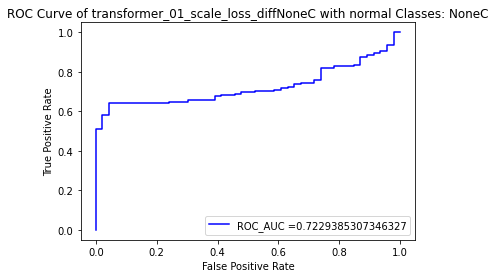

In [28]:

current_time = time.asctime( time.localtime(time.time()) )

fp_rate, tp_rate, _ = roc_curve(targets, anom_scores, pos_label=1)
roc_auc = roc_auc_score(targets, anom_scores)

plt.figure()
plt.plot(fp_rate, tp_rate, color='blue', label=f"ROC_AUC ={roc_auc}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of ' + MODEL_NAME +' with normal Classes: ' + ''.join(NORMAL_CLASSES))
plt.legend(loc="lower right")
plt.savefig('/content/drive/My Drive/models/transformers/roc_graph' + MODEL_NAME+ ''.join(NORMAL_CLASSES) + "_" + str(roc_auc) + ".jpg")
plt.show()

In [29]:
import pytorch_model_summary as pms
summary = pms.summary(model, torch.ones(16, 22, 256).to(device))

In [30]:
print("Traininig finished! Saving Config...")
from google.colab import files

#save hyperparams and result:
with open('/content/drive/My Drive/models/transformers/hyper_params' + MODEL_NAME + '.txt', 'w') as f:
  f.write(f"Model Name: {MODEL_NAME}, Epochs: {EPOCHS}, LR: {LEARNING_RATE}, BatchSize: {BATCH_SIZE}, SAMPLE_RATE = {SAMPLE_RATE}, N_FFT/WINDOW_SIZE = {N_FFT}, HOP_LENGTH = {HOP_LENGTH}, N_MELS = {N_MELS}" 
          + f"NUMBER_OF_FRAMES: {NUMBER_OF_FRAMES}, EMBEDDING_SIZE = {EMBEDDING_SIZE}, N_HEADS = {N_HEADS}, N_ENCODER_LAYERS = {N_ENCODER_LAYERS}, DROPOUT = {DROPOUT}, DIM_FEED_FORWARD = {DIM_FEED_FORWARD}"
  + f"\nNormal Classes: {NORMAL_CLASSES}, Anomalous Classes: {ANOMALOUS_CLASSES}, ROC_AUC Score: {roc_auc}  \n\n {summary}")

Traininig finished! Saving Config...
